In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

import ConstructPortfolio as cp #this will allow us to modularize the code!
#using "ConstructPortfolio.py" that is stored in the same directory! 
#(not using "ConstructPortfolio.ipynb")


/Users/bardiafarajnejad/Desktop/1st Half MFE/AFP/Final Delivery/MFE Group 16 AFP Code


# Trading on earnings suprises (when using midpoint) is not super informative... buy days do slighly better than sell days

# Both buy and sell have high SR of 0.8-0.9 (on 20%+ returns) but low IR of 0.2 (on 2% alpha)

In [2]:
#### Please run the line below once in order to get "data_with_rets.pkl" from "afp_data_sample_1995_onward_v2.csv"
#cp.get_data(flag=True)

data = pd.read_pickle('data_with_rets.pkl')
data

,tradedate,osid,symbol,coname,sector_group,max_dt,previoustradedate,tickssinceipo,alpha,stdev_alpha,...,ret1d_lag,alpha1d_lag,ret5d_lag,alpha5d_lag,ret10d_lag,alpha10d_lag,ret15d_lag,alpha15d_lag,ret20d_lag,alpha20d_lag
0,19950103,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19941230.0,8056,0.010006,0.004670,...,0.00000,-0.003112,0.176850,0.166677,0.131841,0.102035,0.144700,0.123317,0.138261,0.106187
1,19950104,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19950103.0,8057,-0.003112,0.004656,...,0.01929,0.019820,0.131835,0.124719,0.125412,0.099894,0.173638,0.151438,0.144692,0.115932
2,19950105,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19950104.0,8058,0.019820,0.005805,...,0.04732,0.045571,0.119876,0.112258,0.094651,0.075155,0.170357,0.145504,0.135652,0.101416
3,19950106,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19950105.0,8059,0.045571,0.009709,...,0.03313,0.032296,0.069278,0.054748,0.063264,0.050293,0.096391,0.070299,0.090370,0.047479
4,19950109,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19950106.0,8060,0.032296,0.010892,...,0.06706,0.063220,0.058317,0.037605,0.020420,0.006697,0.046651,0.026290,0.072892,0.026535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912427,20210805,78696,COOK,Traeger Inc,7.0,20210805,20210804.0,6,0.047968,0.026349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2912428,20210806,78722,WEBR,Weber Inc Cl A,NaN,20210809,20210805.0,2,0.000000,0.000000,...,0.08190,0.080042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2912429,20210809,78722,WEBR,Weber Inc Cl A,7.0,20210809,20210806.0,3,0.080042,0.025773,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2912430,20210901,78803,FCUV,Focus Universal Inc,NaN,20210902,20210831.0,2,0.000000,0.000000,...,-0.07106,-0.072293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Midpoint Analyst Estimate = (epshigha1 + epslowa1) / 2

### Now, let's trade on earnings suprises!
### the times when 'epsa1' > ('epshigha1' + epslowa1) / 2
###### Buy when positive suprise, so when df['epsa1'] > df['midpoint']
###### Sell when negative suprise, so when df['epsa1'] < df['midpoint']
### with 1 day, 1 week, 2 weeks, 3 weeks, and 4 weeks holding period 
### (AHEAD, not backward... so our ret, ret5d, 10d, 15d, and 20d needs to be forward)
### Thus, we will use ret5d_'lag' !!

# Set buy_tomorrow>0 when df['epsa1'] > df['midpoint']  
### ie earnings falls above MID ESTIMATE!
# Set Sell_tomorrow>0 when df['epsa1'] < df['midpoint']
### ie earnings falls below MID ESTIMATE!

In [3]:
data['duedate'] = pd.to_datetime(data['duedate'], format='%Y%m%d', errors='ignore')


data = data.sort_values(['osid', 'tradedate']).reset_index(drop=True).copy()

data = data[data['epsa1'].notna()].reset_index(drop=True).copy()
data = data[data['epshigha1'].notna()].reset_index(drop=True).copy()
data = data[data['epslowa1'].notna()].reset_index(drop=True).copy()
data = data[data['duedate'].notna()].reset_index(drop=True).copy()

data['midpoint'] = (data['epshigha1']+data['epslowa1']) / 2

data['earnings_delta_surprise'] = (data['epsa1']-data['midpoint'])/data['midpoint'] #(Actual - midpoint)/midpoint predicted

data = data[data['earnings_delta_surprise'].notna()].reset_index(drop=True).copy()

data['buy_tomorrow1'] = np.where(data['earnings_delta_surprise']>0.05, 1, 0)
data['sell_tomorrow1'] = np.where(data['earnings_delta_surprise']<-0.05, 1, 0)

data['buy_tomorrow2'] = np.where( (data['date']-data['duedate']).dt.days == 1, 1, 0)
data['sell_tomorrow2'] = np.where( (data['date']-data['duedate']).dt.days == 1 , 1, 0)

data['buy_tomorrow'] = data['buy_tomorrow1'] + data['buy_tomorrow2']
data['sell_tomorrow'] = data['sell_tomorrow1'] + data['sell_tomorrow2']

data['buy_tomorrow'] = np.where(data['buy_tomorrow']==2, 1, 0)
data['sell_tomorrow'] = np.where(data['sell_tomorrow']==2, 1, 0)



print('Total number of Buys: ',np.count_nonzero(data['buy_tomorrow']))
print('Total number of Sells: ',np.count_nonzero(data['sell_tomorrow']))

print('Unique buy_tomorrow values: ',np.unique(data['buy_tomorrow'])) #there are only 0 or 1 values in 'buy_tomorrow'
print('Unique sell_tomorrow values: ',np.unique(data['sell_tomorrow'])) #there are only 0 or 1 values in 'sell_tomorrow'


Total number of Buys:  54
Total number of Sells:  106
Unique buy_tomorrow values:  [0 1]
Unique sell_tomorrow values:  [0 1]


In [4]:
data = cp.trade_on_valid_lags_only(data)


There are  0  problems for buying

There are  0  problems for selling
Total number of Buys:  54
Total number of Sells:  106


# Now we can trade!
### Holding period of 1 week, 2 weeks, 3 weeks, and 4 weeks with equal weighted portfolios!

# First, create daily equal weighted portfolio weights and returns (NOT AT THE WEEKLY frequency because that will mess up the implementation of the portfolio!). Problem is:

##### Think (part 1): 1st signal on Monday- want to buy on Tuesday and hold for 1 week in an equal weighted portfolio
##### Think (part 2): 2nd signal on Thursday- want to buy on Friday and hold for 1 week in an equal weighted portfolio
##### Think (part 3): Will have overlapping portfolio between 1st and 2nd signal on Friday and on Monday

## Then, for 1 week, 2 week, 3 week, and 4 week holding periods, we must do the following:
##### extend "buy_tomorrow" and "sell_tomorrow" forward for 4 more trading days

In [5]:
data_smaller,data_smaller5,data_smaller10,data_smaller15,data_smaller20 = cp.pull_signal_forward(data)

data_smaller20 = cp.trade_on_valid_lags_only(data_smaller20)
data_smaller15 = cp.trade_on_valid_lags_only(data_smaller15)
data_smaller10 = cp.trade_on_valid_lags_only(data_smaller10)
data_smaller5 = cp.trade_on_valid_lags_only(data_smaller5)
data_smaller = cp.trade_on_valid_lags_only(data_smaller)


There are  0  problems for buying

There are  3  problems for selling
Total number of Buys:  965
Total number of Sells:  1802

There are  0  problems for buying

There are  2  problems for selling
Total number of Buys:  730
Total number of Sells:  1358

There are  0  problems for buying

There are  2  problems for selling
Total number of Buys:  492
Total number of Sells:  913

There are  0  problems for buying

There are  2  problems for selling
Total number of Buys:  252
Total number of Sells:  468

There are  0  problems for buying

There are  0  problems for selling
Total number of Buys:  54
Total number of Sells:  106


# First, do 1 day holding period: data_smaller
# Next, do 5 day holding period: data_smaller5
# Next, do 10 day holding period: data_smaller10
# Next, do 15 day holding period: data_smaller15
# Next, do 20 day holding period: data_smaller20



There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                 -0.046
Method:                 Least Squares   F-statistic:                    0.6467
Date:                Sat, 04 Dec 2021   Prob (F-statistic):              0.692
Time:                        20:23:19   Log-Likelihood:                 114.72
No. Observations:                  49   AIC:                            -215.4
Df Residuals:                      42   BIC: 

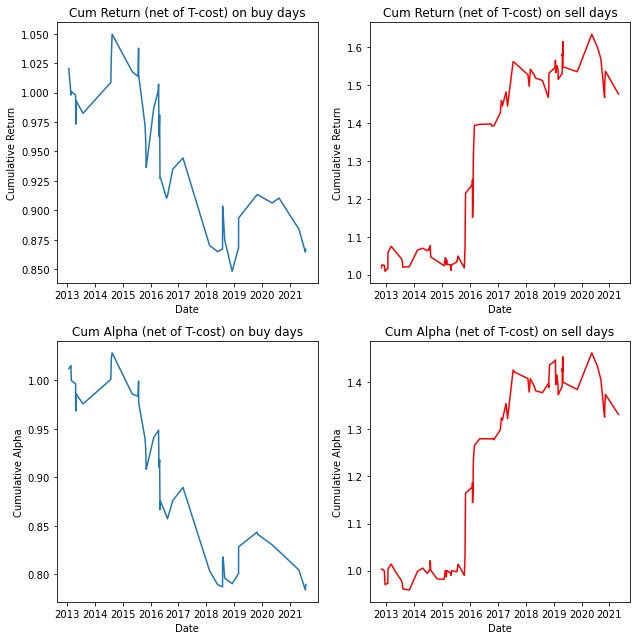

In [6]:
# 1 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     3.240
Date:                Sat, 04 Dec 2021   Prob (F-statistic):            0.00474
Time:                        20:23:36   Log-Likelihood:                 435.81
No. Observations:                 191   AIC:                            -857.6
Df Residuals:                     184   BIC: 

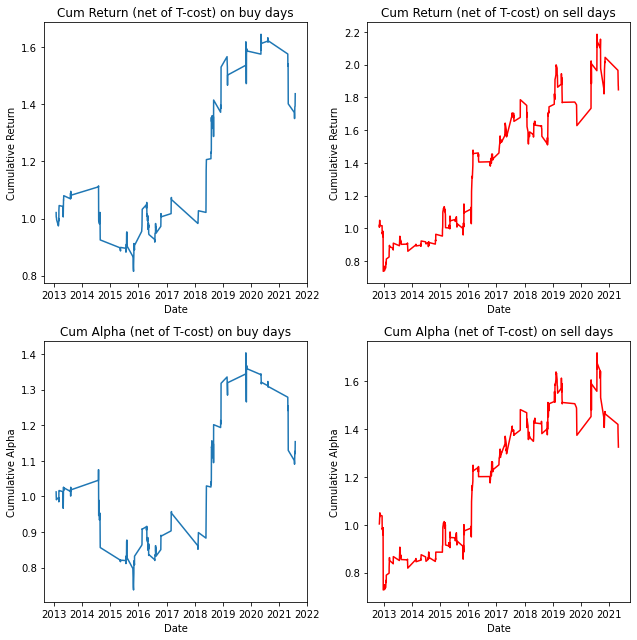

In [7]:
# 5 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller5)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.563
Date:                Sat, 04 Dec 2021   Prob (F-statistic):              0.157
Time:                        20:23:51   Log-Likelihood:                 689.38
No. Observations:                 320   AIC:                            -1365.
Df Residuals:                     313   BIC: 

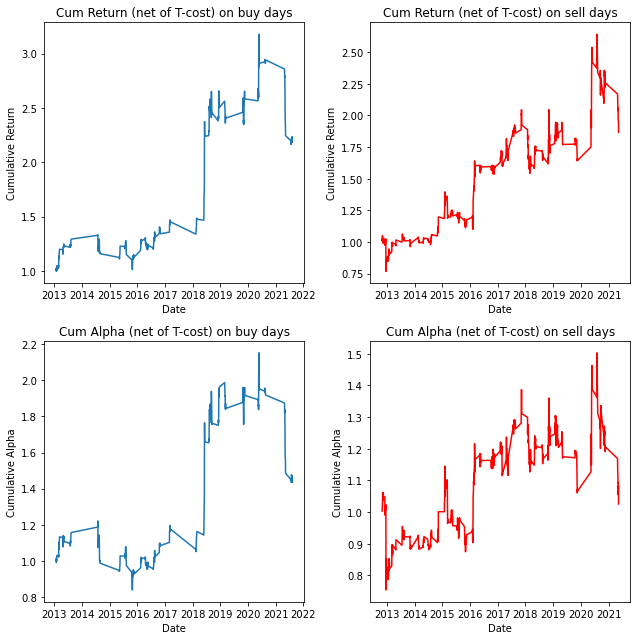

In [8]:
# 10 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller10)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.162
Date:                Sat, 04 Dec 2021   Prob (F-statistic):              0.326
Time:                        20:24:07   Log-Likelihood:                 967.07
No. Observations:                 440   AIC:                            -1920.
Df Residuals:                     433   BIC: 

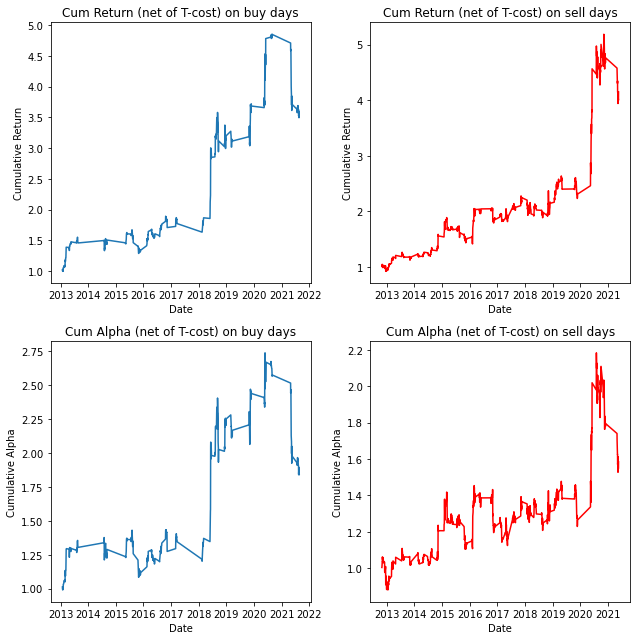

In [9]:
# 15 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller15)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.2805
Date:                Sat, 04 Dec 2021   Prob (F-statistic):              0.946
Time:                        20:24:20   Log-Likelihood:                 1204.2
No. Observations:                 555   AIC:                            -2394.
Df Residuals:                     548   BIC: 

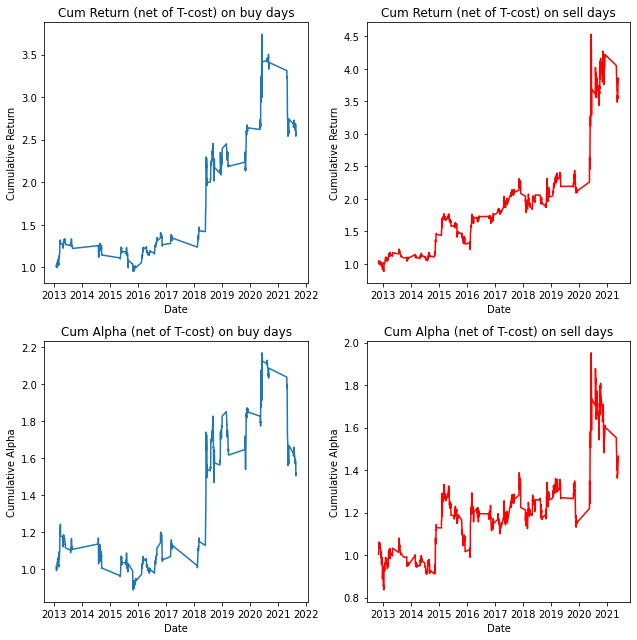

In [10]:
# 20 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller20)